# Data and Package Import

In [229]:
from datetime import date

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import scipy.stats as norm
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Make it easy to see our different features within Jupyter
pd.set_option('display.max_columns', 300)

# Import our test and training datasets from local source
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

# EDA

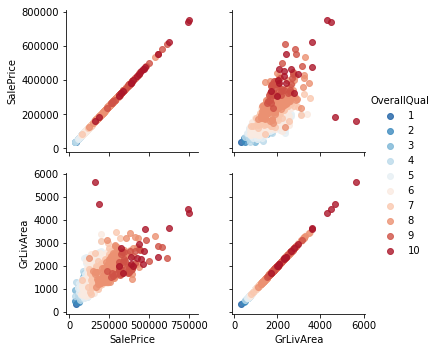

In [230]:
g = sns.PairGrid(train_df, vars=['SalePrice', 'GrLivArea'],
                 hue='OverallQual', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

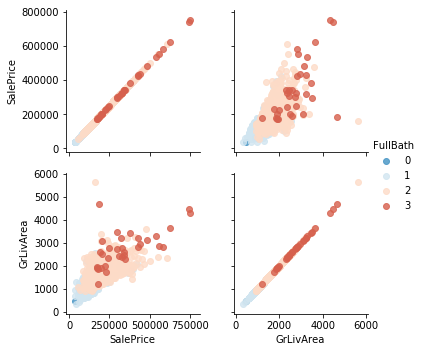

In [231]:
g = sns.PairGrid(train_df, vars=['SalePrice', 'GrLivArea'],
                 hue='FullBath', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

# Target

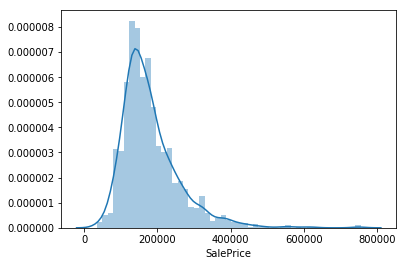

In [232]:
sns.distplot(train_df['SalePrice'])

# Visualizing Some Categorical Variables

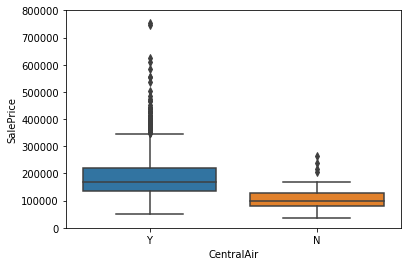

In [233]:
# CentralAir
var = 'CentralAir'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

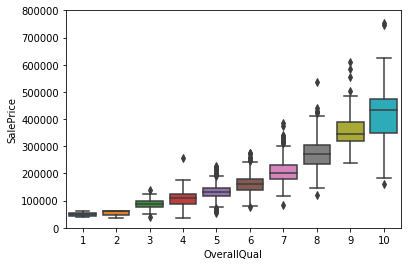

In [234]:
# OverallQual
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

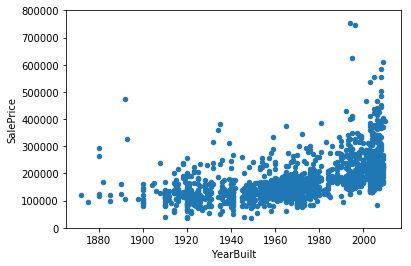

In [235]:
# YearBuilt  scatter
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y="SalePrice", ylim=(0, 800000))

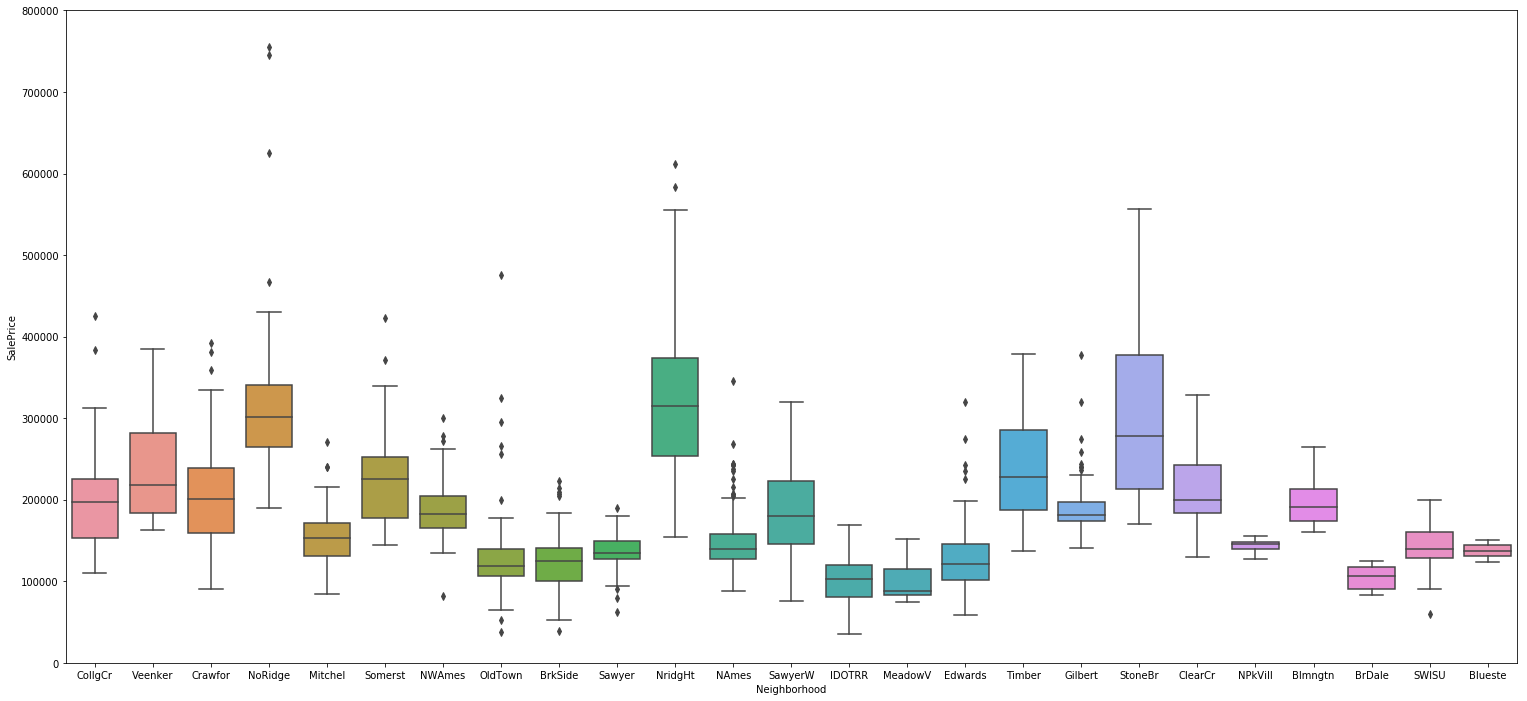

In [236]:
# Neighborhood
var = 'Neighborhood'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(26, 12))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

# Modeling

In [200]:
def convert_categorical_to_dummy(df, columns = [], drop_first = False):
    """
    Convert all categorical variables to k-1 dummy variables
    """
    if len(columns) > 0:
        new_df = pd.get_dummies(df, drop_first = drop_first, columns = columns, drop_na = drop_na)
    else:
        new_df = pd.get_dummies(df, drop_first = drop_frist)
        
    return new_df
        

In [201]:
def recession_indicator(row):
    """Take in sale date and return whether it was during recession
    as determined by official statistics; only include the recession
    which occured during years in question, but can expand as necessary
    https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States"""
    
    period = date(row['YrSold'],row['MoSold'],1)
    if (period >= date(2007,12,1)) & (period <= date(2009,6,1)) :
        return 'recession'
    else:
        return ''

In [202]:
# Convert year based features to age; Most recent year is 2010, so we will treat that as year 0
def convert_year_to_age(df, columns):
    """Helper function to convert year features into age assuming 2010 as year 0"""
    for col in columns:
        df[col] = df[col].apply(lambda x: (2010-x))
    return df

In [203]:
train_df['recession'] = train_df.apply(lambda x: recession_indicator(x), axis = 1)
test_df['recession'] = test_df.apply(lambda x: recession_indicator(x), axis = 1)

In [204]:
# List of columns which we believe it makes sense to convert to boolean
categorical_columns = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
                       'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
                       'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
                       'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC',
                       'CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish',
                       'GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','MoSold','SaleType',
                       'SaleCondition','recession']

new_train = convert_categorical_to_dummy(train_df,categorical_columns)
new_test = convert_categorical_to_dummy(test_df,categorical_columns)

In [205]:
# Get missing columns in the training test
missing_cols = set( new_train.columns ) - set( new_test.columns )

# Add a missing column in test set with default value equal to 0
for col in missing_cols:
    new_test[col] = 0
    
# Ensure matching order and columns 
new_test = new_test[new_train.columns]

In [206]:
# Check to make sure that our missing columns are only derived from the test data lacking specific instances
# of a categorical variable.  Test data set will not have SalePrice (that's target variable Y) so we are alright
for col in missing_cols:
    if col.split("_")[0] not in categorical_columns:
        print("Error, %s was not derived from a missing category" %col)

Error, SalePrice was not derived from a missing category


In [207]:
"""Note: YrSold is different from the other year variables as for the first 3 converting year to age 
from 2010 is a logical conversion assuming linear depreciation (Being built 2 years ago should have twice the 
depreciation effect as 1 year ago, etc.).  However, for year sold we are only covering a 5 year period during which 
there was a significant shock to global financial markets.  As such we will not convert year sold to age,
and opt instead to convert it to a categorical variable (see above)"""


# **** Need to convert this to be age from year sold *****

year_cols = ['YearBuilt','YearRemodAdd','GarageYrBlt']
new_train = convert_year_to_age(new_train,year_cols)
new_test = convert_year_to_age(new_test,year_cols)



In [208]:
# Use SKLearn scaling 
def min_max_scaling(df, columns):
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_df = min_max_scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df,columns = columns)
    return scaled_df, min_max_scaler

# Opt for min-max scaling as opposed to mean normalization as we have so many boolean variables.  Min-Max
# preserve the 0/1 nature of these features.  We may revisit using alternative scaling methods in future
# iterations of preprocessing

scaled_train, min_max_scaler_train = min_max_scaling(new_train, new_train.columns)
scaled_train['Id'] = scaled_train.index + 1

scaled_test = pd.DataFrame(min_max_scaler_train.transform(new_test),columns=new_test.columns)

/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [223]:
## ***** Get all numerical columns with NaN and figure out how to impute| *******

#get all numerical variables
def get_numerical(df):
    numerical = [var for var in df.columns if df[var].dtype!='O']
    return numerical

def findmissingratio(all_data):
    all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    missing_data
    print(missing_data)
    findmissingratio(test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,recession
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,recession
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,recession
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,recession


In [ ]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)


In [ ]:
corrmat = train_df.corr()
k = 10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF','TotRmsAbvGrd', 'YearBuilt']
x = scaled_train[cols].values
y = train_df['SalePrice'].values
y_log = np.log(y.reshape(-1,1))

In [ ]:
# Do K-folds to create train/test splits

In [ ]:
# X_train,X_test, y_train, y_test = train_test_split(x_scaled, y_log, test_size=0.33, random_state=42)

In [ ]:
model = linear_model.LinearRegression()
model.fit(X_train,y_train)
print model.score(X_train,y_train)

In [ ]:
y_pred = model.predict(X_test)
print rmse(y_test,y_pred)

In [ ]:
model.coef_
model.intercept_

In [ ]:
# The "gossip baseline" (e.g. John's house sold for 210k, so I bet that's what we would sell for too)
def super_basic_baseline_neighborhood(train_df, test_df):
    """
    Predict average sale price of homes in that neighborhood.  If does not belong to neighborhood 
    predict average sales price of train set
    """
    return


# The "utility baseline" (e.g. A 3 bedroom, 2 bathroom house, of 2200 sqft provides so much living value)
def super_basic_baseline_home_features(train_df, test_df):
    """K-means++ clustering based on 'normal' home features (beds,baths,sqft)"""
    return


# The "classical analyst baseline" (e.g. How a non-DS focused analyst would approach the problem)
def basic_baseline_lr(train_df, test_df):
    """Train classial linear regression model to predict sales price with all variables"""
    return


def baseline_lr(train_df, test_df):
    """extension of basic baseline where we use L1 regularization and feature selection to 
    make our model more parsimonious, thus (hopefully) improving generalization"""
    return
    


Modeling to do list:

    1) Do all of the below both pre and post PCA

    2) Do all of the below both pre and post k-means++ clustering

Models:

    1) Neural net (Feed Forward)

    2) XGBoost (or RF)

    3) GMM

    4) SVM

    5) KNN (Restrict what features we use)



In [39]:
# PCA + GXBoost = Best | Clay & Rohini prediction
# Lasso Regression     | Mark predicts this will be the hard to beat